<a href="https://colab.research.google.com/github/hsun26/CS445-Project/blob/main/Fianl_Classifcation_DC_(5_classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install torchsummary

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.0 MB/s eta 0:00:00


In [ ]:
from torchsummary import summary
import os
import numpy as np
import seaborn as sns
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

In [ ]:
class HandGestureDataset(Dataset):
    def __init__(self, rgb_dir, mask_dir, transform=None):
        self.rgb_dir = rgb_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        label_mapping = {'one': 0, 'two': 1, 'three': 2, 'four': 3, 'five': 4}

        # Iterate over all categories
        for category in label_mapping:
            rgb_path = os.path.join(self.rgb_dir, category)
            mask_path = os.path.join(self.mask_dir, category)
            for filename in os.listdir(rgb_path):
                if filename.endswith('.jpg'):
                    # Constructing the mask filename based on the RGB filename
                    # RGB filename like '2_Original_046.jpg' corresponds to mask '2_Mask_046.jpg'
                    mask_filename = filename.replace('Original', 'Mask')   # so here I make them matched
                    file_rgb_path = os.path.join(rgb_path, filename)
                    file_mask_path = os.path.join(mask_path, mask_filename)
                    samples.append((file_rgb_path, file_mask_path, label_mapping[category]))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rgb_path, mask_path, label = self.samples[idx]
        rgb_image = Image.open(rgb_path).convert('RGB')
        mask_image = Image.open(mask_path).convert('L')

        if self.transform:
            rgb_image = self.transform(rgb_image)
            mask_image = self.transform(mask_image)

        return rgb_image, mask_image, label

# Transformation to apply
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])



In [ ]:
dataset = HandGestureDataset('/content/drive/MyDrive/CS445/Final Project/rgb', '/content/drive/MyDrive/CS445/Final Project/generate', transform=transform)  #HandGestureDataset(hand_dir, mask_dir, transform=transform)
for i in range(5):  # Check first 5 samples
    print(dataset.samples[i])


('/content/drive/MyDrive/CS445/Final Project/rgb/one/1_Original_003.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/one/1_Mask_003.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/one/1_Original_002.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/one/1_Mask_002.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/one/1_Original_001.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/one/1_Mask_001.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/one/1_Original_004.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/one/1_Mask_004.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/one/1_Original_025.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/one/1_Mask_025.jpg', 0)


In [ ]:
dataset_size = len(dataset)
indices = torch.randperm(dataset_size)  # Shuffle indices

# 80% for training, 20% for testing
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_indices = indices[:train_size]
test_indices = indices[train_size:]

# create subsets using the shuffled indices
train_dataset = torch.utils.data.Subset(dataset, train_indices)  #405
test_dataset = torch.utils.data.Subset(dataset, test_indices)   #102

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)


### DC-CNN (pytorch)

In [ ]:
class DualCNN(nn.Module):
    def __init__(self):
        super(DualCNN, self).__init__()
        # Define the first branch for the RGB image
        self.branch1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5, padding=2),  # Padding=2 to keep size constant
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=7, padding=3),  # Larger kernel and padding
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Define the second branch for the mask image
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Define the fully connected layers
        self.fc1 = nn.Linear(20 * 56 * 56 * 2, 224)  # calculated
        self.fc2 = nn.Linear(224, 5)

    def forward(self, x_img, x_mask):
        out_img = self.branch1(x_img)
        out_mask = self.branch2(x_mask)

        # print("Output size after branch1:", out_img.shape)
        # print("Output size after branch2:", out_mask.shape)

        out_img = out_img.view(out_img.size(0), -1)
        out_mask = out_mask.view(out_mask.size(0), -1)
        out = torch.cat((out_img, out_mask), dim=1)

        # print("Concatenated output size:", out.shape)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Initialize model
model = DualCNN().to(device)
print(model)


DualCNN(
  (branch1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (branch2): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=125440, out_features=224, bias=True)
  (fc2): Linear(in_features=224, out_features=5, bias=True)
)


In [ ]:
# model = DualCNN()
summary(model, [(3, 224, 224), (1, 224, 224)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 224, 224]           1,520
              ReLU-2         [-1, 20, 224, 224]               0
         MaxPool2d-3         [-1, 20, 112, 112]               0
            Conv2d-4         [-1, 20, 112, 112]          19,620
              ReLU-5         [-1, 20, 112, 112]               0
         MaxPool2d-6           [-1, 20, 56, 56]               0
            Conv2d-7         [-1, 20, 224, 224]             520
              ReLU-8         [-1, 20, 224, 224]               0
         MaxPool2d-9         [-1, 20, 112, 112]               0
           Conv2d-10         [-1, 20, 112, 112]          19,620
             ReLU-11         [-1, 20, 112, 112]               0
        MaxPool2d-12           [-1, 20, 56, 56]               0
           Linear-13                  [-1, 224]      28,098,784
           Linear-14                   

In [ ]:
def train_and_test(model, criterion, optimizer, train_loader, val_loader, n_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize lists to store metrics per epoch
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_precisions = []
    epoch_train_recalls = []
    epoch_train_f1s = []
    epoch_val_precisions = []
    epoch_val_recalls = []
    epoch_val_f1s = []

    for epoch in range(n_epochs):
        # Initialize metrics for the current epoch
        train_losses, val_losses = [], []
        train_preds, train_targets = [], []
        val_preds, val_targets = [], []

        # Training Phase
        model.train()
        train_tqdm = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for data_img, data_mask, labels in train_tqdm:
            data_img = data_img.to(device)
            data_mask = data_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(data_img, data_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.detach().cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
            train_tqdm.set_postfix(loss=np.mean(train_losses))

        # Validation Phase
        model.eval()
        val_tqdm = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}')
        with torch.no_grad():
            for data_img, data_mask, labels in val_tqdm:
                data_img = data_img.to(device)
                data_mask = data_mask.to(device)
                labels = labels.to(device)

                outputs = model(data_img, data_mask)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.detach().cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_tqdm.set_postfix(loss=np.mean(val_losses))

        # Calculate metrics for the current epoch
        train_precision = precision_score(train_targets, train_preds, average='macro', zero_division=0)
        train_recall = recall_score(train_targets, train_preds, average='macro', zero_division=0)
        train_f1 = f1_score(train_targets, train_preds, average='macro', zero_division=0)
        val_precision = precision_score(val_targets, val_preds, average='macro', zero_division=0)
        val_recall = recall_score(val_targets, val_preds, average='macro', zero_division=0)
        val_f1 = f1_score(val_targets, val_preds, average='macro', zero_division=0)

        # Store metrics for all epochs
        # epoch_train_losses.append(np.mean(train_losses))
        # epoch_val_losses.append(np.mean(val_losses))
        epoch_train_precisions.append(train_precision)
        epoch_train_recalls.append(train_recall)
        epoch_train_f1s.append(train_f1)
        epoch_val_precisions.append(val_precision)
        epoch_val_recalls.append(val_recall)
        epoch_val_f1s.append(val_f1)

        # End of Epoch Summary
        print(f'Epoch {epoch+1}: Training Loss: {np.mean(train_losses):.4f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1: {train_f1:.2f}')
        print(f'Validation Loss: {np.mean(val_losses):.4f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}')


    epochs = range(1, n_epochs + 1)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, epoch_train_precisions, 'r-', label='Train Precision')
    plt.plot(epochs, epoch_val_precisions, 'b-', label='Test Precision')
    plt.title('Training and Test Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, epoch_train_recalls, 'r-', label='Train Recall')
    plt.plot(epochs, epoch_val_recalls, 'b-', label='Test Recall')
    plt.title('Training and Test Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, epoch_train_f1s, 'r-', label='Train F1 Score')
    plt.plot(epochs, epoch_val_f1s, 'b-', label='Test F1 Score')
    plt.title('Training and Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
model = DualCNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)   # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

Validation Epoch 1: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s, loss=1.59]


Epoch 1: Training Loss: 1.6007, Precision: 0.18, Recall: 0.22, F1: 0.17
Validation Loss: 1.5856, Precision: 0.04, Recall: 0.20, F1: 0.06


Validation Epoch 2: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s, loss=1.57]


Epoch 2: Training Loss: 1.5305, Precision: 0.35, Recall: 0.32, F1: 0.32
Validation Loss: 1.5747, Precision: 0.36, Recall: 0.24, F1: 0.17


Validation Epoch 3: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it, loss=1.39]


Epoch 3: Training Loss: 1.4326, Precision: 0.36, Recall: 0.35, F1: 0.35
Validation Loss: 1.3882, Precision: 0.37, Recall: 0.39, F1: 0.34


Validation Epoch 4: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s, loss=1.37]


Epoch 4: Training Loss: 1.3171, Precision: 0.44, Recall: 0.44, F1: 0.44
Validation Loss: 1.3712, Precision: 0.28, Recall: 0.35, F1: 0.29


Validation Epoch 5: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s, loss=1.36]


Epoch 5: Training Loss: 1.2700, Precision: 0.46, Recall: 0.47, F1: 0.46
Validation Loss: 1.3567, Precision: 0.41, Recall: 0.40, F1: 0.40


Validation Epoch 6: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s, loss=1.28]


Epoch 6: Training Loss: 1.2488, Precision: 0.47, Recall: 0.47, F1: 0.46
Validation Loss: 1.2794, Precision: 0.38, Recall: 0.40, F1: 0.38


Validation Epoch 7: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s, loss=1.28]


Epoch 7: Training Loss: 1.0968, Precision: 0.56, Recall: 0.56, F1: 0.56
Validation Loss: 1.2762, Precision: 0.41, Recall: 0.41, F1: 0.39


Validation Epoch 8: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s, loss=1.35]


Epoch 8: Training Loss: 1.0174, Precision: 0.59, Recall: 0.59, F1: 0.59
Validation Loss: 1.3453, Precision: 0.62, Recall: 0.47, F1: 0.45


Validation Epoch 9: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s, loss=1.25]


Epoch 9: Training Loss: 0.9244, Precision: 0.62, Recall: 0.62, F1: 0.62
Validation Loss: 1.2543, Precision: 0.47, Recall: 0.45, F1: 0.45


Validation Epoch 10: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s, loss=1.33]


Epoch 10: Training Loss: 0.7971, Precision: 0.69, Recall: 0.69, F1: 0.69
Validation Loss: 1.3265, Precision: 0.56, Recall: 0.49, F1: 0.49


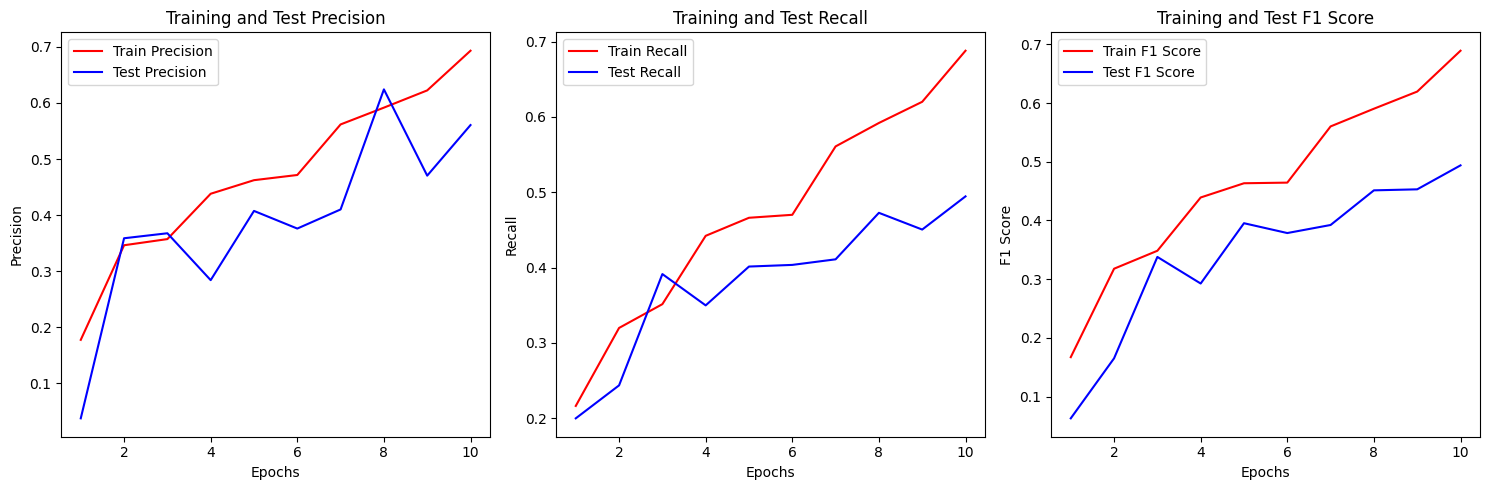

In [ ]:
train_and_test(model, criterion, optimizer, train_loader, test_loader, n_epochs=10)

In [ ]:
model_path = '/content/drive/MyDrive/CS445/Final Project/trained model/DC_CNN_model.pth'
torch.save(model.state_dict(), model_path)

### DC + ResNet18 (LIGHTWEIGHT)

In [ ]:
class DualResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(DualResNet, self).__init__()

        # Initialize ResNet backbones
        self.resnet_branch1 = models.resnet18(pretrained=True)  # pre-trained on imagenet
        self.resnet_branch1.fc = nn.Identity()

        self.resnet_branch2 = models.resnet18(pretrained=True)
        self.resnet_branch2.fc = nn.Identity()

        # Modify the first convolution layer of the second branch to accept 1-channel input
        self.resnet_branch2.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2, 224)  # the output of each ResNet is 512 features
        self.fc2 = nn.Linear(224, num_classes)

    def forward(self, x_img, x_mask):
        # Process inputs through each ResNet branch
        out_img = self.resnet_branch1(x_img)
        out_mask = self.resnet_branch2(x_mask)

        # Concatenate features from both branches
        out = torch.cat((out_img, out_mask), dim=1)

        # Pass through fully connected layers
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Initialize and print model
model_res = DualResNet()
print(model_res)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


DualResNet(
  (resnet_branch1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
optimizer = torch.optim.SGD(model_res.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-04)   # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

Validation Epoch 1: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s, loss=1.64]


Epoch 1: Training Loss: 1.5886, Precision: 0.27, Recall: 0.24, F1: 0.24
Validation Loss: 1.6404, Precision: 0.16, Recall: 0.21, F1: 0.12


Validation Epoch 2: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s, loss=1.18]


Epoch 2: Training Loss: 1.3163, Precision: 0.53, Recall: 0.51, F1: 0.51
Validation Loss: 1.1781, Precision: 0.54, Recall: 0.52, F1: 0.51


Validation Epoch 3: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s, loss=0.848]


Epoch 3: Training Loss: 0.9806, Precision: 0.67, Recall: 0.67, F1: 0.67
Validation Loss: 0.8480, Precision: 0.72, Recall: 0.70, F1: 0.69


Validation Epoch 4: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s, loss=0.752]


Epoch 4: Training Loss: 0.6515, Precision: 0.82, Recall: 0.82, F1: 0.82
Validation Loss: 0.7522, Precision: 0.73, Recall: 0.70, F1: 0.69


Validation Epoch 5: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s, loss=0.603]


Epoch 5: Training Loss: 0.4104, Precision: 0.90, Recall: 0.90, F1: 0.90
Validation Loss: 0.6027, Precision: 0.77, Recall: 0.71, F1: 0.72


Validation Epoch 6: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s, loss=0.564]


Epoch 6: Training Loss: 0.3340, Precision: 0.89, Recall: 0.89, F1: 0.89
Validation Loss: 0.5638, Precision: 0.76, Recall: 0.75, F1: 0.74


Validation Epoch 7: 100%|██████████| 11/11 [00:09<00:00,  1.12it/s, loss=0.544]


Epoch 7: Training Loss: 0.1892, Precision: 0.95, Recall: 0.95, F1: 0.95
Validation Loss: 0.5445, Precision: 0.84, Recall: 0.80, F1: 0.81


Validation Epoch 8: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s, loss=0.508]


Epoch 8: Training Loss: 0.1161, Precision: 0.99, Recall: 0.98, F1: 0.99
Validation Loss: 0.5081, Precision: 0.78, Recall: 0.76, F1: 0.75


Validation Epoch 9: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s, loss=0.518]


Epoch 9: Training Loss: 0.1482, Precision: 0.96, Recall: 0.96, F1: 0.96
Validation Loss: 0.5184, Precision: 0.84, Recall: 0.78, F1: 0.78


Validation Epoch 10: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s, loss=0.591]


Epoch 10: Training Loss: 0.0668, Precision: 1.00, Recall: 1.00, F1: 1.00
Validation Loss: 0.5906, Precision: 0.77, Recall: 0.76, F1: 0.76


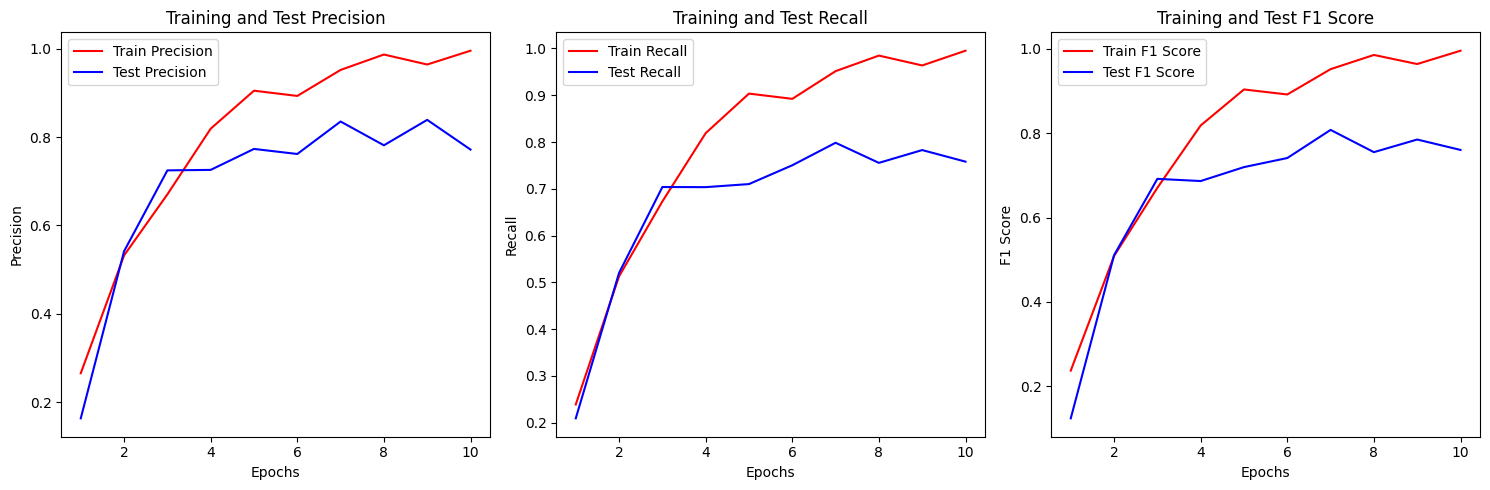

In [ ]:
train_and_test(model_res, criterion, optimizer, train_loader, test_loader, n_epochs=10)

In [ ]:
model_path = '/content/drive/MyDrive/CS445/Final Project/trained model/DC_ResNet_model.pth'
torch.save(model_res.state_dict(), model_path)

### DC + VGG 16

In [ ]:
class DualVGG(nn.Module):
    def __init__(self, num_classes=5):
        super(DualVGG, self).__init__()

        # pre-trained VGG16 for the first branch (handling RGB images)
        base_model1 = models.vgg16(pretrained=True)
        # avgpool
        self.vgg_branch1 = nn.Sequential(
            *base_model1.features,
            base_model1.avgpool,
            nn.Flatten()
        )

        # pre-trained VGG16 for the second branch (handling mask images)
        base_model2 = models.vgg16(pretrained=True)
        # modify the first convolutional layer to accept 1-channel input
        base_model2.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        # avgpool
        self.vgg_branch2 = nn.Sequential(
            *base_model2.features,
            base_model2.avgpool,
            nn.Flatten()
        )

        # Define the classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7 * 2, 4096),  # Adjust based on the output size from the avgpool layer
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes)  # Outputs for 5 classes
        )

    def forward(self, x_img, x_mask):
        x_img = self.vgg_branch1(x_img)
        x_mask = self.vgg_branch2(x_mask)

        # Concatenate
        x = torch.cat((x_img, x_mask), dim=1)

        x = self.classifier(x)
        return x

In [ ]:
model_vgg = DualVGG(num_classes=5)
print(model_vgg)
optimizer = torch.optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-04)   # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 110MB/s]


DualVGG(
  (vgg_branch1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

Validation Epoch 1: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it, loss=1.43]


Epoch 1: Training Loss: 1.5815, Precision: 0.34, Recall: 0.28, F1: 0.26
Validation Loss: 1.4303, Precision: 0.41, Recall: 0.38, F1: 0.34


Validation Epoch 2: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, loss=0.925]


Epoch 2: Training Loss: 1.2591, Precision: 0.51, Recall: 0.51, F1: 0.51
Validation Loss: 0.9248, Precision: 0.80, Recall: 0.65, F1: 0.63


Validation Epoch 3: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s, loss=1.19]


Epoch 3: Training Loss: 0.7803, Precision: 0.70, Recall: 0.70, F1: 0.70
Validation Loss: 1.1928, Precision: 0.77, Recall: 0.53, F1: 0.50


Validation Epoch 4: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s, loss=0.56]


Epoch 4: Training Loss: 0.6193, Precision: 0.79, Recall: 0.79, F1: 0.79
Validation Loss: 0.5596, Precision: 0.75, Recall: 0.73, F1: 0.73


Validation Epoch 5: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, loss=0.656]


Epoch 5: Training Loss: 0.2984, Precision: 0.90, Recall: 0.90, F1: 0.90
Validation Loss: 0.6562, Precision: 0.79, Recall: 0.77, F1: 0.76


Validation Epoch 6: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it, loss=1.11]


Epoch 6: Training Loss: 0.1208, Precision: 0.95, Recall: 0.95, F1: 0.95
Validation Loss: 1.1137, Precision: 0.72, Recall: 0.66, F1: 0.65


Validation Epoch 7: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it, loss=0.578]


Epoch 7: Training Loss: 0.2894, Precision: 0.90, Recall: 0.90, F1: 0.90
Validation Loss: 0.5784, Precision: 0.81, Recall: 0.79, F1: 0.78


Validation Epoch 8: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it, loss=0.407]


Epoch 8: Training Loss: 0.1093, Precision: 0.97, Recall: 0.97, F1: 0.97
Validation Loss: 0.4071, Precision: 0.83, Recall: 0.81, F1: 0.81


Validation Epoch 9: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s, loss=0.505]


Epoch 9: Training Loss: 0.1073, Precision: 0.97, Recall: 0.97, F1: 0.97
Validation Loss: 0.5048, Precision: 0.86, Recall: 0.81, F1: 0.81


Validation Epoch 10: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it, loss=0.39]


Epoch 10: Training Loss: 0.0243, Precision: 1.00, Recall: 1.00, F1: 1.00
Validation Loss: 0.3901, Precision: 0.88, Recall: 0.88, F1: 0.88


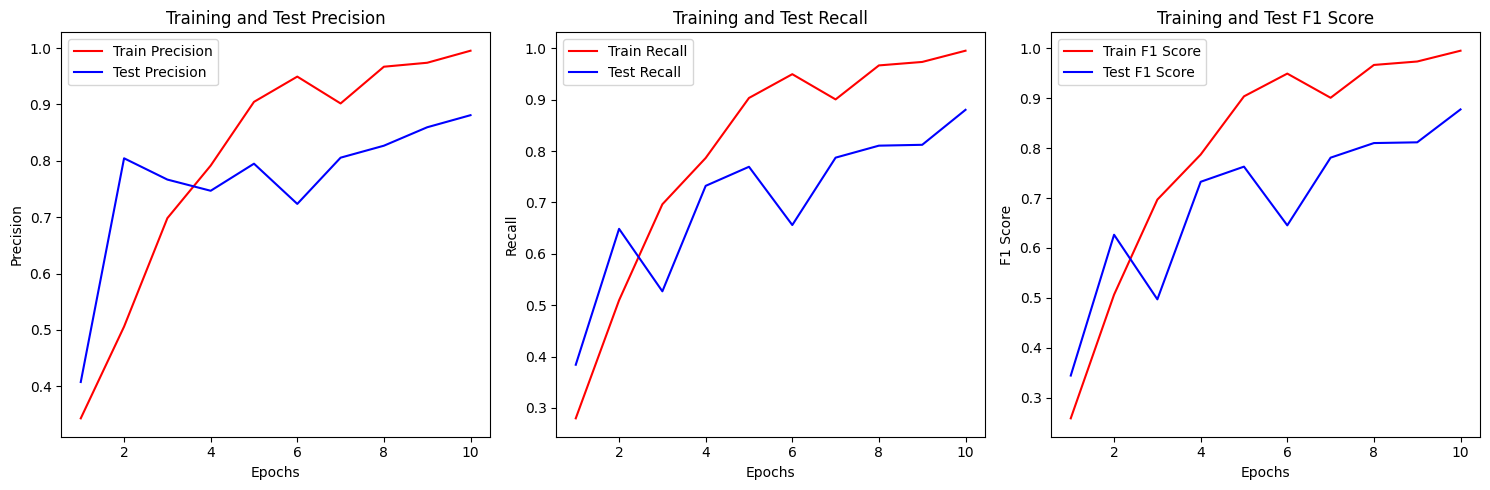

In [ ]:
train_and_test(model_vgg, criterion, optimizer, train_loader, test_loader, n_epochs=10)

In [ ]:
model_path = '/content/drive/MyDrive/CS445/Final Project/trained model/DC_VGG_model.pth'
torch.save(model_vgg.state_dict(), model_path)

### DC+ DenseNet

In [ ]:
class DualDenseNet(nn.Module):
    def __init__(self, num_classes=5):
        super(DualDenseNet, self).__init__()

        #pre-trained DenseNet121 for the first branch (RGB images)
        base_model1 = models.densenet121(pretrained=True)
        self.dense_branch1 = nn.Sequential(*list(base_model1.features), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

        # Load pre-trained DenseNet121 for the second branch (mask images)
        base_model2 = models.densenet121(pretrained=True)
        # Modify to accept 1-channel input
        base_model2.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.dense_branch2 = nn.Sequential(*list(base_model2.features), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

        self.classifier = nn.Sequential(
            nn.Linear(1024 * 2, 512),  # DenseNet121 outputs 1024 features, concatenated from both branches
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x_img, x_mask):
        x_img = self.dense_branch1(x_img)
        x_mask = self.dense_branch2(x_mask)

        # Concatenate
        x = torch.cat((x_img, x_mask), dim=1)

        # Classification
        x = self.classifier(x)
        return x


In [ ]:
model_dense = DualDenseNet(num_classes=5)
print(model_dense)
optimizer = torch.optim.SGD(model_dense .parameters(), lr=0.001, momentum=0.9, weight_decay=1e-04)   # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 90.4MB/s]


DualDenseNet(
  (dense_branch1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=

Validation Epoch 1: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s, loss=1.52]


Epoch 1: Training Loss: 1.5672, Precision: 0.32, Recall: 0.29, F1: 0.29
Validation Loss: 1.5233, Precision: 0.32, Recall: 0.31, F1: 0.23


Validation Epoch 2: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it, loss=1.2]


Epoch 2: Training Loss: 1.3854, Precision: 0.43, Recall: 0.44, F1: 0.43
Validation Loss: 1.2039, Precision: 0.62, Recall: 0.55, F1: 0.50


Validation Epoch 3: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it, loss=0.898]


Epoch 3: Training Loss: 1.0471, Precision: 0.60, Recall: 0.60, F1: 0.59
Validation Loss: 0.8980, Precision: 0.68, Recall: 0.61, F1: 0.58


Validation Epoch 4: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, loss=0.691]


Epoch 4: Training Loss: 0.8040, Precision: 0.71, Recall: 0.71, F1: 0.70
Validation Loss: 0.6911, Precision: 0.76, Recall: 0.74, F1: 0.75


Validation Epoch 5: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s, loss=0.524]


Epoch 5: Training Loss: 0.6004, Precision: 0.78, Recall: 0.78, F1: 0.78
Validation Loss: 0.5241, Precision: 0.83, Recall: 0.79, F1: 0.80


Validation Epoch 6: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, loss=0.483]


Epoch 6: Training Loss: 0.4035, Precision: 0.88, Recall: 0.88, F1: 0.88
Validation Loss: 0.4834, Precision: 0.88, Recall: 0.85, F1: 0.84


Validation Epoch 7: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it, loss=0.507]


Epoch 7: Training Loss: 0.3182, Precision: 0.91, Recall: 0.91, F1: 0.91
Validation Loss: 0.5074, Precision: 0.80, Recall: 0.79, F1: 0.78


Validation Epoch 8: 100%|██████████| 11/11 [00:11<00:00,  1.00s/it, loss=0.481]


Epoch 8: Training Loss: 0.2308, Precision: 0.93, Recall: 0.93, F1: 0.93
Validation Loss: 0.4814, Precision: 0.80, Recall: 0.74, F1: 0.73


Validation Epoch 9: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it, loss=0.455]


Epoch 9: Training Loss: 0.2240, Precision: 0.92, Recall: 0.92, F1: 0.92
Validation Loss: 0.4551, Precision: 0.87, Recall: 0.86, F1: 0.85


Validation Epoch 10: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it, loss=0.468]


Epoch 10: Training Loss: 0.2261, Precision: 0.93, Recall: 0.92, F1: 0.92
Validation Loss: 0.4678, Precision: 0.83, Recall: 0.78, F1: 0.79


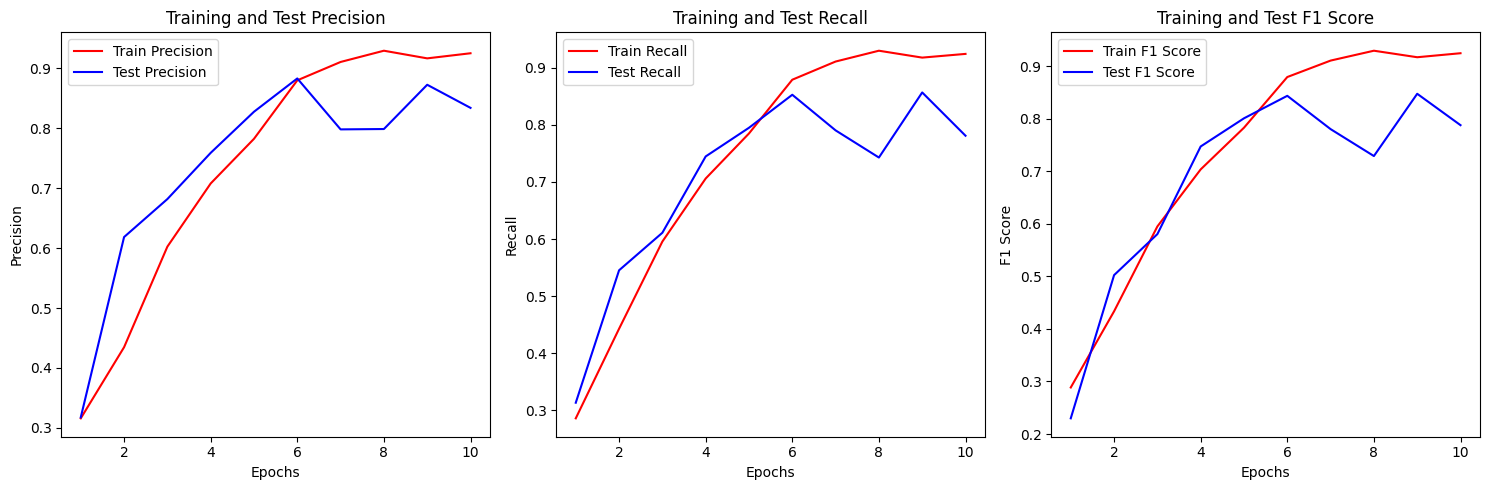

In [ ]:
train_and_test(model_dense, criterion, optimizer, train_loader, test_loader, n_epochs=10)

In [ ]:
model_path = '/content/drive/MyDrive/CS445/Final Project/trained model/DC_DenseNet_model.pth'
torch.save(model_dense.state_dict(), model_path)

### Final Test

In [ ]:
class HandGestureTestDataset(Dataset):
    def __init__(self, rgb_dir, mask_dir, transform=None):
        self.rgb_dir = rgb_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.label_mapping = {
            '1': 0, '2': 1, '3': 2, '4': 3, '5': 4
        }
        self.samples = self._load_samples()

    # def _load_samples(self):
    #     samples = []

    #     # Iterate over all categories specified in the label mapping
    #     for category, label in self.label_mapping.items():
    #         rgb_path = os.path.join(self.rgb_dir, category)
    #         mask_path = os.path.join(self.mask_dir, category)

    #         # Ensure both directories exist
    #         if os.path.exists(rgb_path) and os.path.exists(mask_path):
    #             for filename in os.listdir(rgb_path):
    #                 if filename.endswith('.jpg'):
    #                     # Construct the corresponding mask filename
    #                     mask_filename = filename.replace('rgb', 'Predicted_Mask')
    #                     file_rgb_path = os.path.join(rgb_path, filename)
    #                     file_mask_path = os.path.join(mask_path, mask_filename)

    #                     # Check if the mask file exists before adding to samples
    #                     if os.path.exists(file_mask_path):
    #                         samples.append((file_rgb_path, file_mask_path, label))

    #     return samples
    def _load_samples(self):
        samples = []

        # Iterate over all categories specified in the label mapping
        for category, label in self.label_mapping.items():
            rgb_path = os.path.join(self.rgb_dir, category)
            mask_path = os.path.join(self.mask_dir, category)

            # Print to see if the directories exist
            print(f"Checking directories for category '{category}'")
            print(f"RGB directory: {rgb_path} (Exists: {os.path.exists(rgb_path)})")
            print(f"Mask directory: {mask_path} (Exists: {os.path.exists(mask_path)})")

            # Ensure both directories exist
            if os.path.exists(rgb_path) and os.path.exists(mask_path):
                for filename in os.listdir(rgb_path):
                    if filename.endswith('.jpg'):
                        # Construct the corresponding mask filename
                        mask_filename = filename.replace('rgb', 'Predicted_Mask')
                        file_rgb_path = os.path.join(rgb_path, filename)
                        file_mask_path = os.path.join(mask_path, mask_filename)

                        # Check if the mask file exists before adding to samples
                        if os.path.exists(file_mask_path):
                            samples.append((file_rgb_path, file_mask_path, label))
                        else:
                            print(f"Missing mask file: {file_mask_path}")
                    else:
                        print(f"Ignored non-JPG file: {filename}")

            else:
                print(f"Directory missing for category '{category}'")

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rgb_path, mask_path, label = self.samples[idx]
        rgb_image = Image.open(rgb_path).convert('RGB')
        mask_image = Image.open(mask_path).convert('L')

        if self.transform:
            rgb_image = self.transform(rgb_image)
            mask_image = self.transform(mask_image)

        return rgb_image, mask_image, label


# Usage
rgb_dir = '/content/drive/MyDrive/CS445/Final Project/test_final/rgb'
mask_dir = '/content/drive/MyDrive/CS445/Final Project/test_final/mask'

final_dataset = HandGestureTestDataset(rgb_dir, mask_dir, transform=transform)


Checking directories for category '1'
RGB directory: /content/drive/MyDrive/CS445/Final Project/test_final/rgb/1 (Exists: True)
Mask directory: /content/drive/MyDrive/CS445/Final Project/test_final/mask/1 (Exists: True)
Checking directories for category '2'
RGB directory: /content/drive/MyDrive/CS445/Final Project/test_final/rgb/2 (Exists: True)
Mask directory: /content/drive/MyDrive/CS445/Final Project/test_final/mask/2 (Exists: True)
Checking directories for category '3'
RGB directory: /content/drive/MyDrive/CS445/Final Project/test_final/rgb/3 (Exists: True)
Mask directory: /content/drive/MyDrive/CS445/Final Project/test_final/mask/3 (Exists: True)
Checking directories for category '4'
RGB directory: /content/drive/MyDrive/CS445/Final Project/test_final/rgb/4 (Exists: True)
Mask directory: /content/drive/MyDrive/CS445/Final Project/test_final/mask/4 (Exists: True)
Checking directories for category '5'
RGB directory: /content/drive/MyDrive/CS445/Final Project/test_final/rgb/5 (Exists

In [ ]:
final_test_loader = DataLoader(final_dataset, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

predictions = []
labels_list = []

# no gradient needed for evaluation
with torch.no_grad():
    for data in final_test_loader:
        inputs_rgb, inputs_mask, labels = data  # Unpack the RGB images, masks, and labels

        inputs_rgb = inputs_rgb.to(device)
        inputs_mask = inputs_mask.to(device)
        labels = labels.to(device)

        outputs = model(inputs_rgb, inputs_mask)
        _, predicted = torch.max(outputs, 1)  # get the predicted classes

        # Convert to the CPU
        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

predictions = np.array(predictions)
labels_list = np.array(labels_list)

# precision, recall, F1-score, confusion_matrix
precision = precision_score(labels_list, predictions, average='macro')
recall = recall_score(labels_list, predictions, average='macro')
f1 = f1_score(labels_list, predictions, average='macro')
conf_matrix = confusion_matrix(labels_list, predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Precision: 0.34
Recall: 0.25
F1-Score: 0.17
Confusion Matrix:
[[4 0 1 4 1]
 [4 0 0 6 0]
 [6 0 1 3 0]
 [2 0 1 8 0]
 [4 0 2 5 0]]


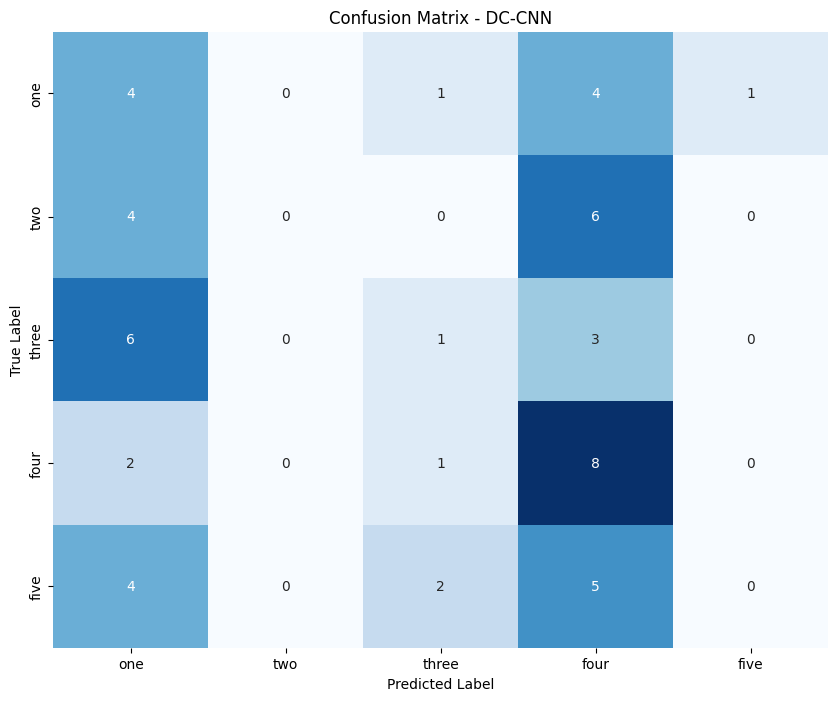

In [ ]:
label_names = ['one', 'two', 'three', 'four', 'five']

# Convert the names to the corresponding numeric labels for the confusion matrix
numeric_labels = [0, 1, 2, 3, 4]

conf_matrix = confusion_matrix(labels_list, predictions, labels=numeric_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DC-CNN")
plt.show()


ResNet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_res.to(device)
model_res.eval()

predictions = []
labels_list = []

with torch.no_grad():
    for data in final_test_loader:
        inputs_rgb, inputs_mask, labels = data

        inputs_rgb = inputs_rgb.to(device)
        inputs_mask = inputs_mask.to(device)
        labels = labels.to(device)

        outputs = model_res(inputs_rgb, inputs_mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes

        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

predictions = np.array(predictions)
labels_list = np.array(labels_list)

precision = precision_score(labels_list, predictions, average='macro')
recall = recall_score(labels_list, predictions, average='macro')
f1 = f1_score(labels_list, predictions, average='macro')
conf_matrix = confusion_matrix(labels_list, predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Precision: 0.44
Recall: 0.28
F1-Score: 0.25
Confusion Matrix:
[[ 2  2  1  5  0]
 [ 0  1  4  5  0]
 [ 0  0  0 10  0]
 [ 0  0  0  9  2]
 [ 0  0  3  5  3]]


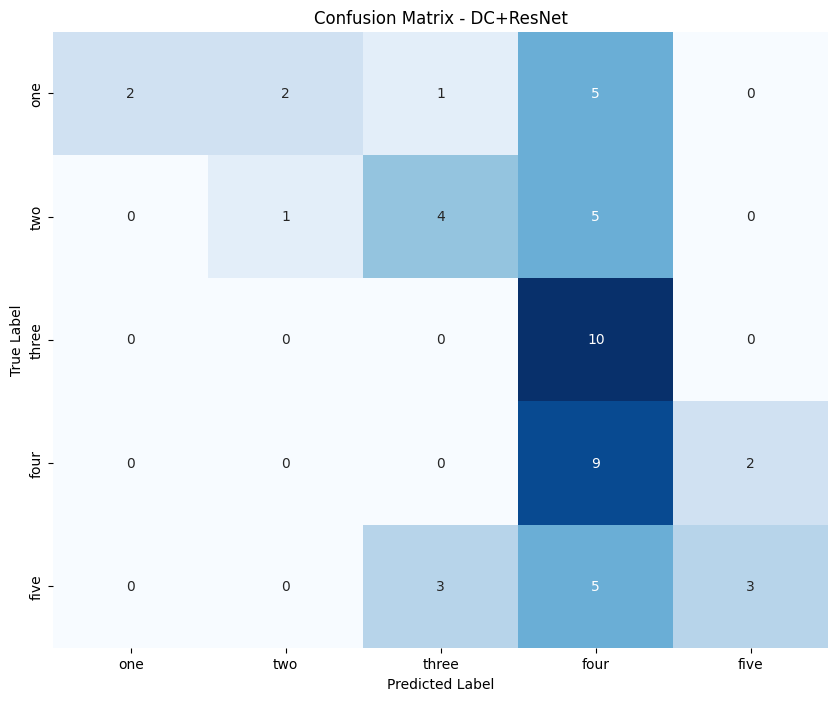

In [ ]:
label_names = ['one', 'two', 'three', 'four', 'five']

# Convert the names to the corresponding numeric labels for the confusion matrix
numeric_labels = [0, 1, 2, 3, 4]

conf_matrix = confusion_matrix(labels_list, predictions, labels=numeric_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DC+ResNet")
plt.show()


VGG

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg.to(device)
model_vgg.eval()

predictions = []
labels_list = []

with torch.no_grad():
    for data in final_test_loader:
        inputs_rgb, inputs_mask, labels = data

        inputs_rgb = inputs_rgb.to(device)
        inputs_mask = inputs_mask.to(device)
        labels = labels.to(device)

        outputs = model_vgg(inputs_rgb, inputs_mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes

        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

predictions = np.array(predictions)
labels_list = np.array(labels_list)

precision = precision_score(labels_list, predictions, average='macro')
recall = recall_score(labels_list, predictions, average='macro')
f1 = f1_score(labels_list, predictions, average='macro')
conf_matrix = confusion_matrix(labels_list, predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Precision: 0.18
Recall: 0.26
F1-Score: 0.20
Confusion Matrix:
[[0 4 4 1 1]
 [0 1 5 3 1]
 [0 0 0 8 2]
 [0 0 0 7 4]
 [0 0 0 5 6]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


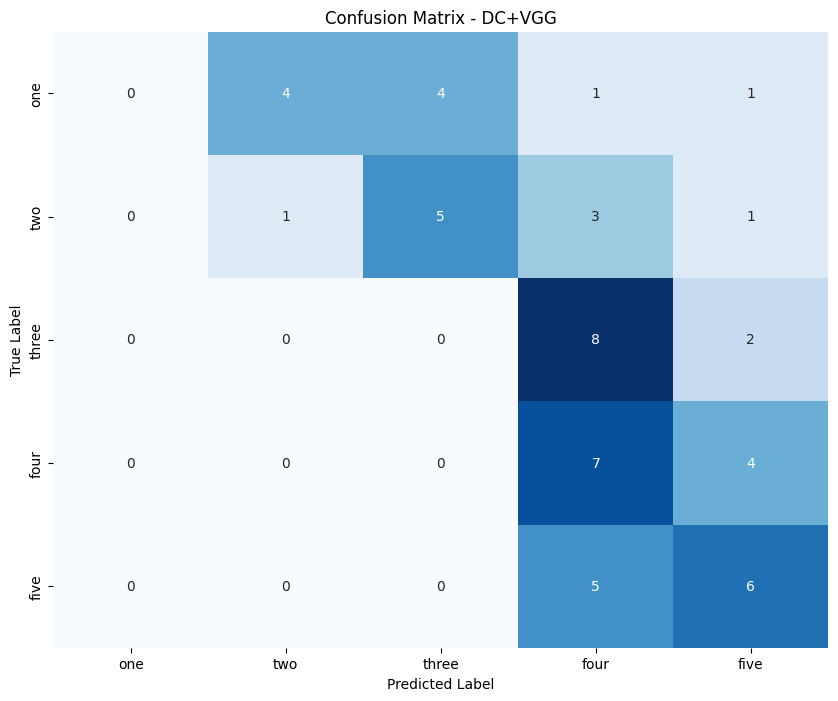

In [ ]:
label_names = ['one', 'two', 'three', 'four', 'five']

# Convert the names to the corresponding numeric labels for the confusion matrix
numeric_labels = [0, 1, 2, 3, 4]

conf_matrix = confusion_matrix(labels_list, predictions, labels=numeric_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DC+VGG")
plt.show()


DenseNet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dense.to(device)
model_dense.eval()

predictions = []
labels_list = []

with torch.no_grad():
    for data in final_test_loader:
        inputs_rgb, inputs_mask, labels = data

        inputs_rgb = inputs_rgb.to(device)
        inputs_mask = inputs_mask.to(device)
        labels = labels.to(device)

        outputs = model_dense(inputs_rgb, inputs_mask)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

predictions = np.array(predictions)
labels_list = np.array(labels_list)

precision = precision_score(labels_list, predictions, average='macro')
recall = recall_score(labels_list, predictions, average='macro')
f1 = f1_score(labels_list, predictions, average='macro')
conf_matrix = confusion_matrix(labels_list, predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Precision: 0.47
Recall: 0.43
F1-Score: 0.41
Confusion Matrix:
[[7 2 0 1 0]
 [0 2 2 5 1]
 [0 0 0 9 1]
 [0 0 0 9 2]
 [0 0 1 5 5]]


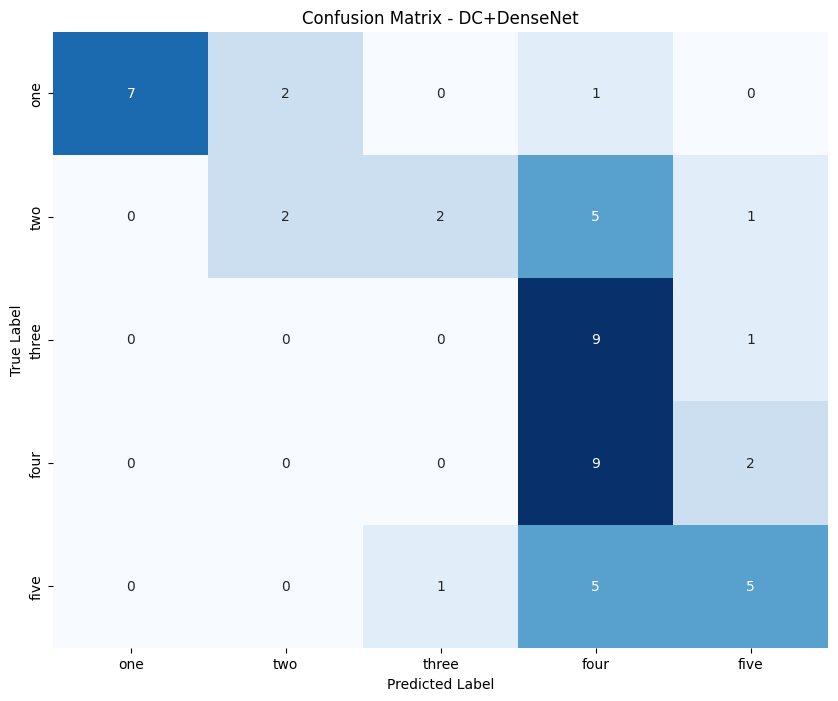

In [ ]:
label_names = [ 'one', 'two', 'three', 'four', 'five']

# Convert the names to the corresponding numeric labels for the confusion matrix
numeric_labels = [0, 1, 2, 3, 4]

conf_matrix = confusion_matrix(labels_list, predictions, labels=numeric_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DC+DenseNet")
plt.show()
